In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\student\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\student\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\student\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\student\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# **1. Pre-Processing**
1. Tokenization
2. Stemming/lemmatization
3. Bow/TF-IDF 

In [2]:
from nltk.stem import WordNetLemmatizer
import re
import numpy as np
      
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [3]:
def tokenize_lemmatizor(frame):
    words = []
    lemma_words = []
    lemma_sentences = []
    lemmatizer = WordNetLemmatizer()

    for i in range(len(frame)):
        words = nltk.word_tokenize(frame.iloc[i])
        lemma_words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
        lemma_sentences.append(" ".join(lemma_words))

    return lemma_sentences

In [4]:
def re_lemmatizor(frame):
    lemmatizer = WordNetLemmatizer()
    review = []
    corpus = []

    for i in range(len(frame)):
        review = re.sub('[^a-zA-Z]', ' ', frame.iloc[i])
        review = review.lower()
        review = review.split()
        # these lines represent - words = nltk.word_tokenize(frame.cmd[i])

        review = [lemmatizer.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
        # lemma_words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))])
        
        corpus.append(" ".join(review))
        # lemma_sentences.append(" ".join(lemma_words))

    return corpus

### 3.1. BOW

In [5]:
def custom_tokens_bow(corpus_tokens):
    tokens = re_lemmatizor(corpus_tokens)
    vocab = []
    for sentence in tokens:
        vocab.extend(sentence.split())
    
    features = list(set(vocab))
    bow = []
    for sentence in tokens:
        sent_dict = {}
        for word in sentence.split():
            sent_dict[word] = sent_dict.get(word, 0) + 1
        bow.append([sent_dict[feature] if feature in sent_dict.keys() else 0 for feature in features ])
    # print("Total Vocab Count:", len(features))
    features = np.array(features)
    return np.array(bow), features

In [6]:
from sklearn.feature_extraction.text import CountVectorizer # bow
def tokens_to_bow(corpus_tokens, tokenizer=1):
    cv = CountVectorizer(max_features=5000)
    tokens = []
    if tokenizer == 1:
        tokens = tokenize_lemmatizor(corpus_tokens)
        X_bow = cv.fit_transform(tokens).toarray()
    else:
        tokens = re_lemmatizor(corpus_tokens)
        X_bow = cv.fit_transform(tokens).toarray()
    features = cv.get_feature_names_out()
    return X_bow, features

### 3.2. TF-IDF

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer # tfidf
def tokens_to_tfidf(corpus_tokens, tokenizer=1):
    tfidf = TfidfVectorizer()
    tokens = []
    if tokenizer:
        tokens = tokenize_lemmatizor(corpus_tokens)
        X_tfidf = tfidf.fit_transform(tokens).toarray()
    else:
        tokens = re_lemmatizor(corpus_tokens)
        X_tfidf = tfidf.fit_transform(tokens).toarray()
    return X_tfidf, tokens

## **Implementation**

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from random import randint, choices, randrange, random, sample, shuffle

In [9]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score

In [10]:
from sklearn.model_selection import train_test_split
def split(df,label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

In [11]:
classifiers = ['LinearSVM', 'RadialSVM', 
               'Logistic',  'RandomForest', 
               'DecisionTree', 'KNeighbors',
               'MultinomialNB']
               

In [12]:
models = [svm.SVC(kernel='linear'),
          svm.SVC(kernel='rbf'),
          LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          DecisionTreeClassifier(random_state=0),
          KNeighborsClassifier(),
          MultinomialNB()]

In [13]:
def acc_score(df,label):
    Score = pd.DataFrame({"Classifier":classifiers})
    j = 0
    acc = []
    exec_time = []
    X_train,X_test,Y_train,Y_test = split(df,label)
    for i in models:
        model = i

        st = time.time()
        model.fit(X_train,Y_train)
        et = time.time()

        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test,predictions))
        exec_time.append(et-st)
        j = j+1     
    Score["Accuracy"] = acc
    Score['Exec_Time_secs'] = exec_time
    Score.sort_values(by="Accuracy", ascending=False,inplace = True)
    Score.reset_index(drop=True, inplace=True)
    return Score

In [14]:
def plot(score,x,y,c = "b"):
    gen = [1,2,3,4,5]
    plt.figure(figsize=(6,4))
    ax = sns.pointplot(x=gen, y=score,color = c )
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x,y))

In [15]:
def initial_population_term_selection_tf(tf_terms, tf_threshold):
    selected_indexes = []
    selected_terms = []
    tf_dict = dict(tf_terms)
    for word, tf in tf_dict.items():
        if tf >= tf_threshold:
            selected_terms.append(word)
            selected_indexes.append(all_terms.index(word))
    return selected_indexes, selected_terms

len(initial_population_term_selection_tf(tf_terms, 0.001)[1])
1566
len(initial_population_term_selection_tf(tf_terms, 0.002)[1])
655
len(initial_population_term_selection_tf(tf_terms, 0.003)[1])
427

In [16]:
def initial_population_term_selection_idf(idf, idf_threshold):
    selected_indexes = []
    selected_terms = []
    idf_dict = dict(idf)
    for word, idf in idf_dict.items():
        if idf <= idf_threshold:
            selected_terms.append(word)
            selected_indexes.append(all_terms.index(word))
    return selected_indexes, selected_terms

len(initial_population_term_selection_idf(idf, 2.6)[1])
418
len(initial_population_term_selection_idf(idf, 2.7)[1])
651
len(initial_population_term_selection_idf(idf, 2.8)[1])
651
len(initial_population_term_selection_idf(idf, 2.9)[1])
651
len(initial_population_term_selection_idf(idf, 3)[1])
1553

In [17]:
def generate_chromo(selected_indexes, features_count, chromo_size):
    features = sample(selected_indexes, k=features_count)
    features.sort()
    chromo = [1 if i in features else 0 for i in range(chromo_size)]
    return np.array(chromo)

In [18]:
def generate_population(size, features_count, chromo_size, selected_indexes):
    return [generate_chromo(selected_indexes, features_count, chromo_size) for _ in range(size)]

In [19]:
def single_point_crossover(pop_after_sel, probability):
    shuffle(list(pop_after_sel))
    pop_nextgen = pop_after_sel
    length = len(pop_nextgen)
    chrom_l = len(pop_nextgen[0])

    tf_idf_sent_score = dict(term_frequency_inverse_document_frequency(pop_after_sel))
    pop_sorted_tfidf = np.array(sorted(tf_idf_sent_score.items(), key=lambda x: x[1], reverse=True))[:, 0]
    
    mid = len(pop_sorted_tfidf)//2
    pop_1 = pop_sorted_tfidf[:mid]
    pop_2 = pop_sorted_tfidf[mid:]
    
    i=0
    j=0
    m = len(pop_1)
    n = len(pop_2)
    # print(m, n)
    
    while i<m and j<n:
        parent_1, parent_2 = pop_after_sel[int(pop_1[i])], pop_after_sel[int(pop_2[j])]
        if random() <= probability:
            k = randint(1, chrom_l - 1)  # crossover_point
            new_child_1 = np.concatenate([parent_1[:k], parent_2[k:]])
            new_child_2 = np.concatenate([parent_2[:k], parent_1[k:]])
            pop_nextgen.append(new_child_1)
            pop_nextgen.append(new_child_2)
        else:
            pop_nextgen.append(parent_1)
            pop_nextgen.append(parent_2)
        i+=1
        j+=1
        
    while i<m:
        parent_1 = pop_after_sel[int(pop_1[i])]
        pop_nextgen.append(parent_1)
        i+=1
    
    while j<n:
        parent_2 = pop_after_sel[int(pop_2[j])]
        pop_nextgen.append(parent_2)
        j+=1
    
    return pop_nextgen

In [20]:
def single_point_crossover1(pop_after_sel, n_parents):
    shuffle(list(pop_after_sel))
    pop_nextgen = pop_after_sel.copy()
    length = len(pop_nextgen)
    chromo_l = len(pop_nextgen[0])

    tf_idf_sent_score = dict(term_frequency_inverse_document_frequency(pop_after_sel))
    pop_sorted_tfidf = np.array(sorted(tf_idf_sent_score.items(), key=lambda x: x[1]))[:, 0]
    
    mid = len(pop_sorted_tfidf)//2
    pop_1 = pop_sorted_tfidf[:mid]
    pop_2 = pop_sorted_tfidf[mid:]

    for i in range(0, mid):
        parent_1, parent_2 = pop_after_sel[int(pop_1[i])].copy(), pop_after_sel[int(pop_2[i])].copy()
        p1_features = list(np.where(np.array(parent_1) != 0)[0])
        p2_features = list(np.where(np.array(parent_2) != 0)[0])

        k = randint(0,len(p1_features))  # crossover_point
        c1_features = p1_features[:k] + p2_features[k:]
        c2_features = p2_features[:k] + p1_features[k:]

        c1_dup = list(set([i for i in c1_features if c1_features.count(i) > 1]))
        c2_dup = list(set([i for i in c2_features if c2_features.count(i) > 1]))
            # print("duplicates:", c1_dup, c2_dup)
            
        if len(c1_dup) > 0:
            sample_pop1 = [i for i in p1_features if i not in c1_features]
            k1 = sample(sample_pop1, k=len(c1_dup))
            for i in c1_dup:
                c1_features.remove(i)
            c1_features.extend(k1)
        elif len(c2_dup) > 0:
            sample_pop2 = [i for i in p2_features if i not in c2_features]
            k2 = sample(sample_pop2, k=len(c2_dup))
            for i in c2_dup:
                c2_features.remove(i)
            c2_features.extend(k2)

        new_child_1 = np.array([1 if i in c1_features else 0 for i in range(chromo_l)])
        new_child_2 = np.array([1 if i in c2_features else 0 for i in range(chromo_l)])
        pop_nextgen.append(new_child_1)
        pop_nextgen.append(new_child_2)
        
    _, pop_nextgen = fitness_score(pop_nextgen)
    return pop_nextgen[:n_parents]

In [21]:
def bit_flip_mutation(pop_after_cross, probability, mutation_rate1, mutation_rate2, n_feat):   
    n_feat = pop_after_cross[0].shape[0]
    # print(n_feat)
    
    range1 = int(mutation_rate1*n_feat)
    range2 = int(mutation_rate2*n_feat)
    pop_next_gen = []
    
    tf_idf_sent_score = dict(term_frequency_inverse_document_frequency(pop_after_cross))
    pop_sorted_tfidf = np.array(sorted(tf_idf_sent_score.items(), key=lambda x: x[1], reverse=True))[:, 0]
    
    mid = len(pop_sorted_tfidf)//2+1
    for n in pop_sorted_tfidf:
        if mid >= 0:
            mutation_range = range1
        else:
            mutation_range = range2
            
        chromo = pop_after_cross[int(n)]
        rand_posi = []
        if random() <= probability:
            for i in range(0,mutation_range):
                pos = randint(0,n_feat-1)
                rand_posi.append(pos)
            for j in rand_posi:
                chromo[j] = abs(chromo[j] - 1)
        pop_next_gen.append(chromo)
        mid -= 1
    
    return pop_next_gen

In [22]:
def bit_flip_mutation1(pop_after_cross, mutation_rate1, mutation_rate2, features_count, n_parents):   
    range1 = int(mutation_rate1*features_count)
    range2 = int(mutation_rate2*features_count)
    pop_next_gen = pop_after_cross.copy()
    # print(range1, range2)
    tf_idf_sent_score = dict(term_frequency_inverse_document_frequency(pop_after_cross))
    pop_sorted_tfidf = np.array(sorted(tf_idf_sent_score.items(), key=lambda x: x[1]))[:, 0]
    
    mid = len(pop_sorted_tfidf)//2+1
    for n in pop_sorted_tfidf:
        if mid >= 0:
            mutation_range = range1
        else:
            mutation_range = range2
            
        chromo = pop_after_cross[int(n)].copy()
        features = list(np.where(chromo != 0)[0])
        non_features = list(np.setdiff1d(np.array(range(chromo.shape[0])), features))

        rand_posi = []

        features_pos = sample(features, k=mutation_range)
        non_features_pos = sample(non_features, k=mutation_range)
        rand_posi.extend(features_pos)
        rand_posi.extend(non_features_pos)
        for j in rand_posi:
            chromo[j] = abs(chromo[j] - 1)
            
        pop_next_gen.append(chromo)
        mid -= 1

    _, pop_next_gen = fitness_score(pop_next_gen)
    return pop_next_gen[:n_parents+20]

In [23]:
def varient_pressure_selection(pop_after_fit, tfidf_threshold):
    tf_idf_sent_score = term_frequency_inverse_document_frequency(pop_after_fit)
    sent_indexes = [i for i, j in tf_idf_sent_score if j <= tfidf_threshold]
    sent_indexes.sort()
    population_nextgen = []
    for i in sent_indexes:
        population_nextgen.append(pop_after_fit[i])
    # print("from selec: ", tf_idf_sent_score)
    return population_nextgen

In [26]:
def fitness_score(population):
    scores = []
    for chromosome in population:
        indexes = np.where(chromosome!=0)[0]
        logmodel.fit(X_train[:,indexes],Y_train)    
        predictions = logmodel.predict(X_test[:,indexes])
        scores.append(accuracy_score(Y_test,predictions))
    scores, population = np.array(scores), np.array(population)
    inds = np.argsort(scores)
    return list(scores[inds][::-1]), list(population[inds,:][::-1])

In [27]:
def term_frequency(population):
    tf_sent = []
    tf_dict = {}
    total_no_terms = len(population)
    for chromosome in population:
        chromo_tf = []
        indexes = np.where(chromosome!=0)
        for i in indexes[0]:
            chromo_tf.append(chromosome[i]/total_no_terms)
            tf_dict[all_terms[i]] = tf_dict.get(all_terms[i], 0) + (chromosome[i]/total_no_terms)
        tf_sent.append(chromo_tf)
    
    tf_terms = sorted(tf_dict.items(), key=lambda x: x[1], reverse=True)
    return tf_sent, tf_terms

In [28]:
def inverse_document_frequency(population):
    idf = {}
    terms = np.array(list(all_terms))
    no_documents = len(population)
    for i in range(len(all_terms)):
        k = 0
        for chromosome in population:
            indexes = np.where(chromosome!=0)
            if terms[i] in terms[indexes]:
                k += 1
        idf[terms[i]] = np.log10(no_documents/k)
    idf = sorted(idf.items(), key=lambda x: x[1], reverse=True)
    return idf

In [29]:
def term_frequency_inverse_document_frequency(population):
    tf_sent, tf_terms = term_frequency(population)
    tf_idf = {}
    idf_dict = dict(idf)
    for i in range(len(population)):
        tf_idf_sent = []
        indexes = np.where(population[i] != 0)[0]
        for j in range(len(indexes)):
            idf_term = idf_dict[all_terms[indexes[j]]]
            tf = tf_sent[i][j]
            tf_idf_sent.append(tf*idf_term)
        tf_idf[i] = sum(tf_idf_sent)/len(indexes)
    tf_idf = sorted(tf_idf.items(), key=lambda x: x[1], reverse=True)
    return tf_idf

In [30]:
def evolution(size, features_count, chromo_size,
            n_parents,
            mutation_rate1,
            mutation_rate2,
            n_gen,
            idf, idf_threshold,
            tfidf_threshold):
    best_chromo= []
    best_score= []
    
    
    selected_indexes, selected_terms = initial_population_term_selection_idf(idf, idf_threshold)
    # selected_indexes, selected_terms = initial_population_term_selection_tf(tf, tf_threshold)

    population_nextgen=generate_population(size, features_count, chromo_size, selected_indexes)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
        print('Best score in generation',i+1,':',scores[0], "feat_count:", np.where(pop_after_fit[0] != 0)[0].shape)
        print("after fitness:", len(pop_after_fit[:n_parents]))

        pop_after_sel = varient_pressure_selection(pop_after_fit, tfidf_threshold)
        # sc_sel, pop_sel = fitness_score(pop_after_sel)
        # print('Best score in generation',i+1,':',sc_sel[0], "feat_count:", np.where(pop_sel[0] != 0)[0].shape)
        print("after selection:", len(pop_after_sel))

        pop_after_cross = single_point_crossover1(pop_after_sel, n_parents)
        # sc_co, pop_co = fitness_score(pop_after_cross)
        # print('Best score in generation',i+1,':',sc_co[0], "feat_count:", np.where(pop_co[0] != 0)[0].shape)
        print("after crossover:", len(pop_after_cross))

        population_nextgen = bit_flip_mutation1(pop_after_cross, mutation_rate1, mutation_rate2, features_count, n_parents)
        # sc_mu, pop_mu = fitness_score(population_nextgen)
        # print('Best score in generation',i+1,':',sc_mu[0], "feat_count:", np.where(pop_mu[0] != 0)[0].shape)
        
        # # new next gen population will have the evolved population + the initial population after fitness_score
        # population_nextgen += pop_after_sel
        # _, population_new_nextgen = fitness_score(population_nextgen)
        # print('Best score in generation',i+1,':',_[0], "feat_count:", np.where(population_new_nextgen[0] != 0)[0].shape)
        # population_nextgen = population_selection(population_new_nextgen, n_parents)
        print(len(population_nextgen))
        
    return best_chromo,best_score

# **Accuracy Comparison**

## **For Amazon dataset**

### Data Preprocessing

In [31]:
amazon = pd.read_csv("../dataset/amazon.csv", encoding="latin1")
frame = amazon.copy()
frame

,cmd,score
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


*Difference between a stemmed and lemmatized words*

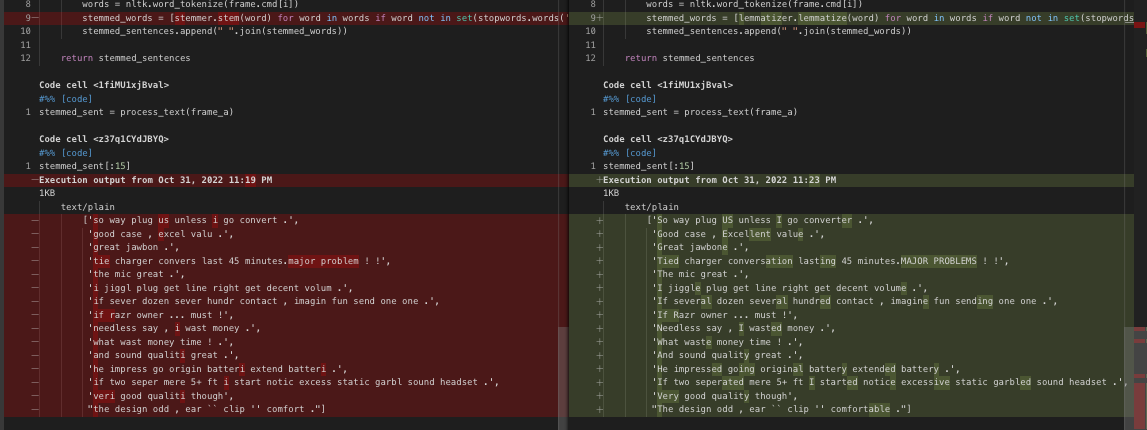

In [32]:
X_bow, features = tokens_to_bow(frame.cmd, 0)
y_score = frame.score
all_terms = list(features)

In [33]:
X_train, X_test, Y_train, Y_test = split(X_bow, y_score)

In [34]:
idf = inverse_document_frequency(X_bow)
tf_sent, tf_terms = term_frequency(X_bow)

In [38]:
selected_indexes, selected_terms = initial_population_term_selection_idf(idf, 2.7)
population_nextgen=generate_population(100, 100, 1553, selected_indexes)
scores, pop_after_fit = fitness_score(population_nextgen)
tf_idf_sent_score = term_frequency_inverse_document_frequency(pop_after_fit)

In [39]:
tf_idf_sent_score

[(90, 0.025013947767001957),
 (52, 0.02460292595104744),
 (57, 0.024593009432310686),
 (72, 0.02452271404510518),
 (94, 0.024502514077657255),
 (24, 0.024472477472920792),
 (84, 0.024471765845382718),
 (9, 0.024441812220379697),
 (40, 0.02442042556354872),
 (51, 0.024389679015512103),
 (11, 0.024376060561842317),
 (43, 0.0243677018258754),
 (74, 0.024364950010611827),
 (29, 0.024363161307443437),
 (35, 0.024344894913308344),
 (60, 0.0243291908604364),
 (87, 0.02432225159410647),
 (47, 0.024313707662578878),
 (78, 0.02426928930977251),
 (73, 0.02425013896910874),
 (81, 0.024243769338870975),
 (61, 0.024231021823315664),
 (71, 0.02422366344931226),
 (91, 0.024176405663309728),
 (16, 0.024173400993555097),
 (58, 0.024162285358845494),
 (92, 0.02413846454284666),
 (79, 0.02413429397713772),
 (93, 0.02413198677955181),
 (1, 0.024086888129343915),
 (76, 0.024081057475770093),
 (32, 0.024070243758750883),
 (18, 0.024060891781051162),
 (41, 0.024057594790721355),
 (65, 0.02405601190810794),
 (

### Compare models without GA

In [35]:
all_models_score_table = acc_score(X_bow, y_score)
all_models_score_table

,Classifier,Accuracy,Exec_Time_secs
0,RandomForest,0.800,4.514945
1,MultinomialNB,0.796,0.041948
2,LinearSVM,0.780,1.977607
3,Logistic,0.776,0.133819
4,DecisionTree,0.772,0.864518
5,RadialSVM,0.756,2.019315
6,KNeighbors,0.648,0.000000


### Choosing the best classifier and starting evolution

In [36]:
logmodel = RandomForestClassifier(n_estimators=200, random_state=0)

### Trying different parameters

In [40]:
st = time.time()
chromo_set_1, score_set_1 = evolution(
    size=100, 
    features_count=100,
    chromo_size=X_bow.shape[1],
    n_parents=80,
    mutation_rate1=0.05,
    mutation_rate2=0.1,
    n_gen=20,
    idf = idf,
    idf_threshold=2.7,
    tfidf_threshold = 0.0241
)
et = time.time()

Best score in generation 1 : 0.692 feat_count: (100,)
after fitness: 80
[(43, 0.02446652886970525), (91, 0.024418254938923308), (34, 0.024373019684903748), (25, 0.024344459490965694), (80, 0.024342898238836275), (69, 0.024339771754996117), (85, 0.02424739289949919), (27, 0.024244984277719026), (97, 0.024238108109008345), (84, 0.024211133646085667), (52, 0.02420668315346501), (22, 0.024185788713727424), (99, 0.024160373894067028), (50, 0.02412702104924713), (16, 0.02411341872223402), (21, 0.02411204418457937), (60, 0.02411072634960828), (93, 0.02410747143287091), (46, 0.024086897927346702), (5, 0.024066307505021367), (23, 0.024065064329617542), (57, 0.024052765210362495), (62, 0.024052563891427556), (32, 0.02405025063511217), (96, 0.024047203281845994), (94, 0.02403405580474425), (67, 0.024030006833088664), (86, 0.024026019302862203), (83, 0.02401294533706934), (95, 0.024012114558825442), (24, 0.024004097957286245), (31, 0.023996929759146166), (79, 0.023994024758436597), (47, 0.02398336

In [ ]:
import pickle
with open('single_run_az_kbga_vp.pkl', 'wb') as wf:
    pickle.dump([chromo_set_1, score_set_1, et-st], wf)

In [ ]:
# si = initial_population_term_selection_idf(idf, 2.7)[0]
# pop = generate_population(100, 100, 1553, si)

In [ ]:
# try to corr map for accuracy and tfidf

In [42]:
def run_n_evolution(n):
    result_n_runs = []
    for i in range(n):
        st = time.time()
        chromo_set_2, score_set_2 = evolution(
        size=100, 
        features_count=100,
        chromo_size=X_bow.shape[1],
        n_parents=80,
        mutation_rate1=0.05,
        mutation_rate2=0.1,
        n_gen=100,
        idf = idf,
        idf_threshold=2.7,
        tfidf_threshold = 0.0241
        )
        et = time.time()
        result_n_runs.append((chromo_set_2, score_set_2, et-st))
    return result_n_runs

In [43]:
results = run_n_evolution(5)

Best score in generation 1 : 0.664 feat_count: (100,)
after fitness: 80
[(27, 0.024751771608075686), (66, 0.0245567110482084), (43, 0.02452429774735272), (86, 0.024457924213474112), (48, 0.024455111982870124), (19, 0.024372620349492658), (44, 0.024368245712668046), (63, 0.02436092336879896), (97, 0.02435088532700087), (58, 0.02434637507240703), (95, 0.024342855725089523), (59, 0.024324317242773646), (55, 0.024308693340271872), (81, 0.02426675001920555), (70, 0.024264838477433125), (85, 0.024217002157646952), (78, 0.024197546576728124), (84, 0.024181830246357446), (8, 0.02417879229478799), (10, 0.02417803030153481), (33, 0.02417755283740081), (2, 0.02414967956171925), (17, 0.02410046554848457), (36, 0.024098384518928647), (82, 0.024085725824750114), (54, 0.024076828067000663), (91, 0.024074251360553463), (98, 0.024056515361038377), (72, 0.024053695453975083), (35, 0.024031649016732777), (12, 0.024027841760143057), (26, 0.024016655663335676), (64, 0.024010884260412594), (32, 0.0240019588

In [44]:
import pickle
with open('n_run_az_kbga_vp.pkl', 'wb') as wf:
    pickle.dump(results, wf)